# Imports

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [85]:
df = pd.read_csv("../diabetes_binary_classification_data.csv")

df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Data Split

In [86]:
X = df.copy().drop(["Diabetes_binary"], axis=1)
y = df.copy()["Diabetes_binary"].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

# Data Analysis

In [96]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190260 entries, 29352 to 121958
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                190260 non-null  float64
 1   HighChol              190260 non-null  float64
 2   CholCheck             190260 non-null  float64
 3   BMI                   190260 non-null  float64
 4   Smoker                190260 non-null  float64
 5   Stroke                190260 non-null  float64
 6   HeartDiseaseorAttack  190260 non-null  float64
 7   PhysActivity          190260 non-null  float64
 8   Fruits                190260 non-null  float64
 9   Veggies               190260 non-null  float64
 10  HvyAlcoholConsump     190260 non-null  float64
 11  AnyHealthcare         190260 non-null  float64
 12  NoDocbcCost           190260 non-null  float64
 13  GenHlth               190260 non-null  float64
 14  MentHlth              190260 non-null  float64
 15  P

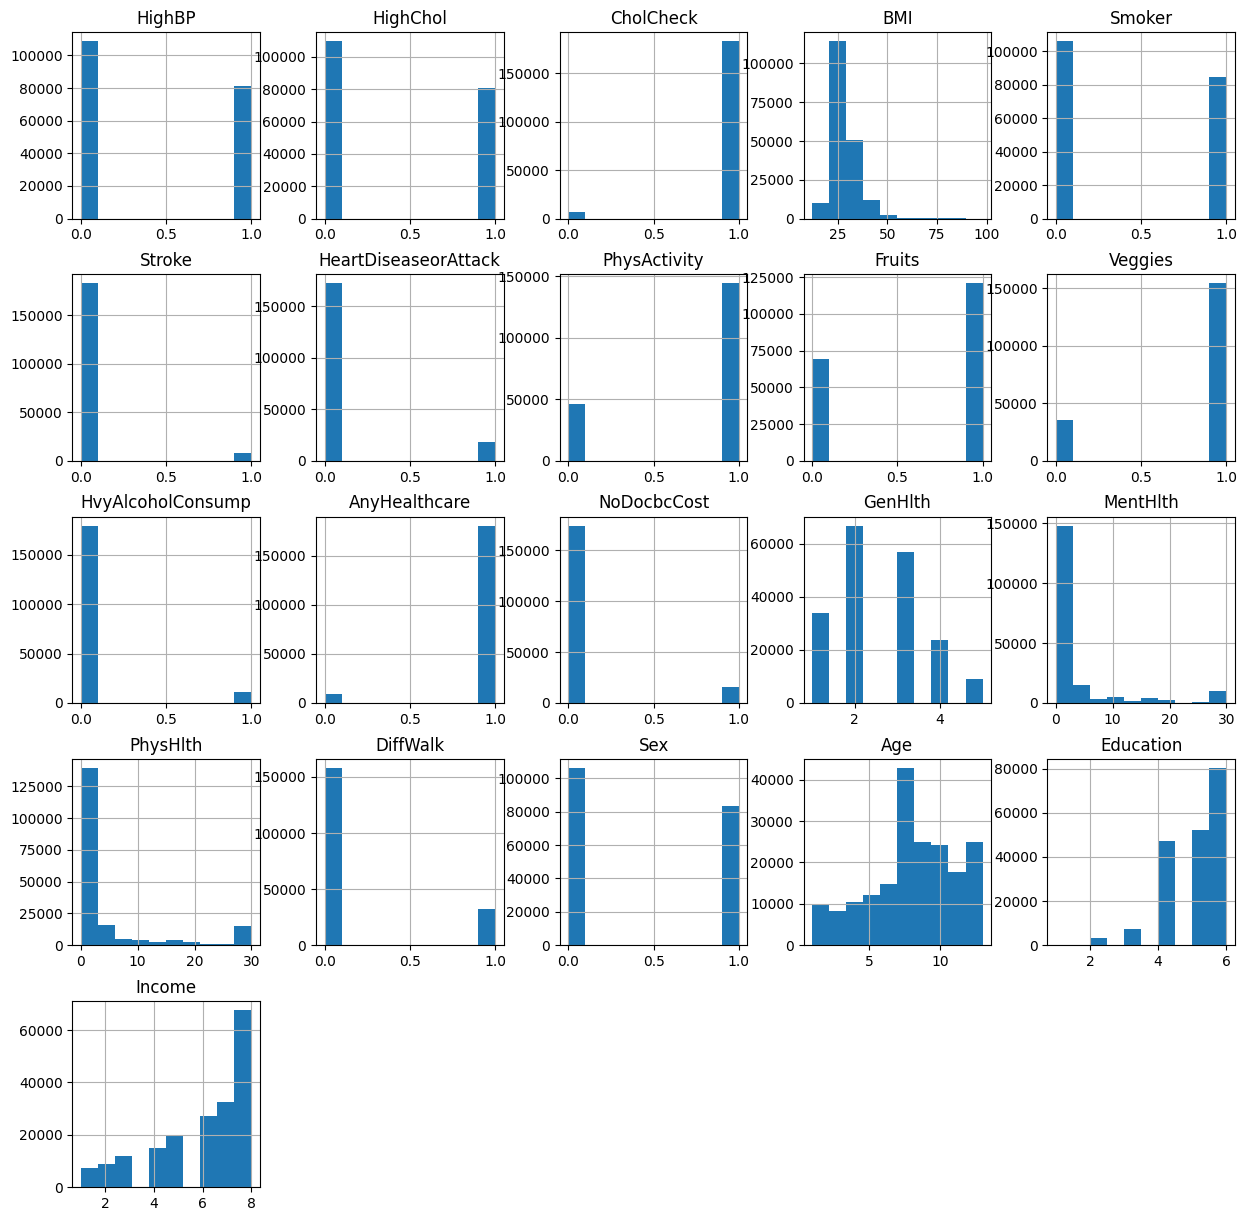

In [87]:
X_train.hist(figsize=(15, 15));

<Axes: >

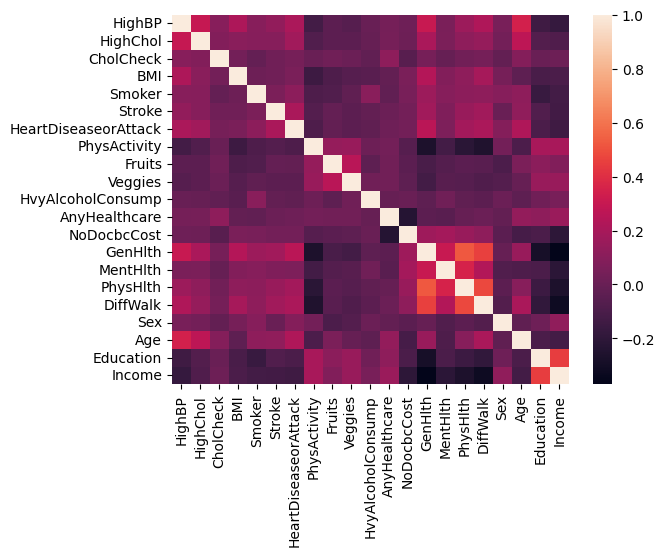

In [88]:
corr = X_train.corr()
sb.heatmap(corr)

# Dummy Classifier

In [89]:
classifier = DummyClassifier(random_state=40)
classifier.fit(X_train, y_train)

,strategy,'prior'
,random_state,40
,constant,None


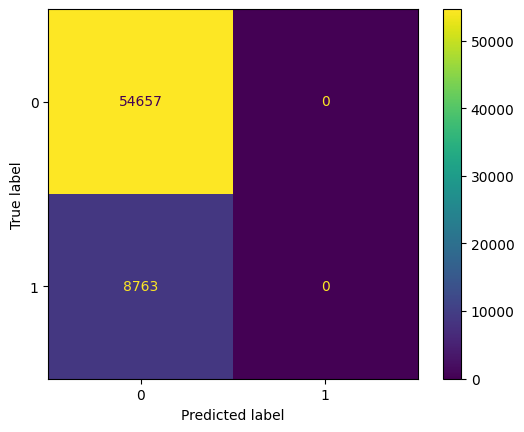

In [90]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()


In [91]:
y_train.value_counts()

Diabetes_binary
0.0                163677
1.0                 26583
Name: count, dtype: int64

# SGD Classifier

In [92]:
sgdClassifier = SGDClassifier()
sgdClassifier.fit(X_train, y_train)


c:\Users\stian\Documents\School\BIDATA_5\Maskin\NTNU-IE500618-Assignment-2\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


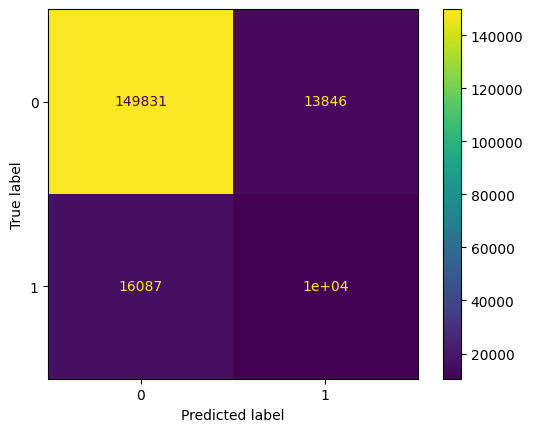

In [93]:
y_pred = sgdClassifier.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

ConfusionMatrixDisplay(cm).plot()

# KNeighborsClassifier

In [94]:
knClassifier = KNeighborsClassifier()
knClassifier.fit(X_train, y_train)

c:\Users\stian\Documents\School\BIDATA_5\Maskin\NTNU-IE500618-Assignment-2\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


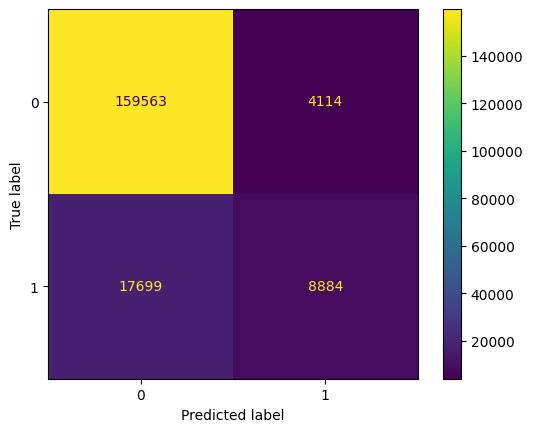

In [95]:
y_pred = knClassifier.predict(X_train)
cm = confusion_matrix(y_train, y_pred)

ConfusionMatrixDisplay(cm).plot()